In [1]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
import numpy as np

In [13]:
# Extract top n words and full words from each file. Used for a stratified vocab and for documents to feed into tfidf
def extract_words(filename, N):
    print(f"Processing {filename}...")
    df = pd.read_csv(filename)
    # fill in missing values with an empty string
    df = df.fillna("")
    df = df[df["language"] != "UNKNOWN"]
    df = df[df["language"] != "CSV"]
    df = df[df["language"] != "DOTFILE"]
    df = df[df["language"] != "TSV"]
    #df.to_csv("language-snippets-all.csv")
    # top_words = [word for word, count in Counter(" ".join(df["snippet"]).lower().split()).most_common(N)]
    words = df["snippet"].tolist()
    df.loc[df["language"] == "Shell", "language"] = "Bash"
    label = df["language"].tolist()
    return words, label

# files = ["snippets-bash.csv", "snippets-c.csv", "snippets-cpp.csv", "snippets-csv.csv", 
#          "snippets-dotfile.csv", "snippets-go.csv", "snippets-html.csv", "snippets-java.csv", "snippets-javascript.csv",
#          "snippets-json.csv"]

files = ["snippets-all.csv"]

# Loosely based off number of reserved keywords per language. Trying to upper bound to track most common keywords 
# and other common symbols in each language 
# https://stackoverflow.com/questions/4980766/reserved-keywords-count-by-programming-language
N = 20

snippets = []
labels = []
for file in files:
    snippet_list, label = extract_words(file, N)
    snippets += snippet_list
    labels += label

Processing snippets-all.csv...


In [14]:
print(snippets[:5])
print(list(set(list(labels))))

["const nconf = require('nconf');\n\nconst db = require('./mocks/databasemock');\nconst helpers = require('./helpers');\nconst Groups = require('../src/groups');\n", "\t\t// create another group that starts with test for search/sort\n\t\tawait Groups.create({\tname: 'Test2', description: 'Foobar!' });\n\n\t\ttestUid = await User.create({\n\t\t\tusername: 'testuser',\n", '\n\t\t\t\tdone();\n\t\t\t});\n\t\t});\n\n', '\t\t\t\tassert.deepStrictEqual(isMembers, [true, false]);\n\t\t\t\tdone();\n\t\t\t});\n\t\t});\n\t});\n', '\t\t\t\t\tdone();\n\t\t\t\t});\n\t\t\t});\n\t\t});\n\n']
['Bash', 'C++', 'JavaScript', 'YAML', 'Jupyter', 'Go', 'C', 'Text', 'HTML', 'Markdown', 'Java', 'Ruby', 'Rust', 'Python', 'PowerShell', 'JSON']


In [15]:
#vectorizer = TfidfVectorizer(vocabulary=vocabulary)
vectorizer = TfidfVectorizer(max_features = 2000, ngram_range=(1, 2), token_pattern=r"(?u)\b[A-Za-z_]+\b|[:={}<>,#\[\]]|\/\/")
X = vectorizer.fit_transform(snippets)
# Lots of garbage in our features, e.g. '2', 'sherlock', '"",', 'carolina,south', '"仄仄平平仄，平平仄仄平"'
# Could be improved by creating smarter tokens, or engineering the vocabulary a bit more. 
print(vectorizer.get_feature_names())

['#', '# #', '# ,', '# <', '# >', '# [', '# ]', '# define', '# else', '# endif', '# if', '# ifdef', '# ifndef', '# include', '# {', ',', ', #', ', ,', ', //', ', :', ', <', ', =', ', >', ', [', ', ]', ', _', ', a', ', and', ', args', ', author', ', b', ', bing', ', bing_en', ', bool', ', but', ', c', ', char', ', column', ', const', ', ctxt', ', d', ', data', ', description', ', dev', ', e', ', either', ', end', ', err', ', error', ', f', ', false', ', flags', ', function', ', g', ', google', ', h', ', hi', ', i', ', id', ', if', ', in', ', including', ', int', ', integrity', ', is', ', it', ', k', ', key', ', l', ', len', ', like', ', lo', ', m', ', n', ', name', ', new', ', nil', ', null', ', o', ', object', ', offset', ', ok', ', omitempty', ', optional', ', options', ', or', ', out', ', p', ', paragraphs', ', path', ', r', ', requires', ', resolved', ', result', ', s', ', self', ', size', ', size_t', ', sizeof', ', so', ', software', ', source', ', span', ', start', ', std', ', str

In [16]:
languages = list(set(labels))
encoding = { language: number for language, number in zip(languages, range(len(languages)))}
# One-hot encode the language
y = pd.get_dummies(map(lambda x: encoding[x], labels))
print(X)
print(y)

print(X.shape[0])
print(len(y))

  (0, 269)	0.6703792564453676
  (0, 1606)	0.13581322315971553
  (0, 648)	0.16195758309035216
  (0, 1473)	0.5795236113571886
  (0, 221)	0.1773073012094422
  (0, 592)	0.37233139410960725
  (1, 667)	0.1893695363672711
  (1, 42)	0.2125932123955404
  (1, 149)	0.10978597814172601
  (1, 1217)	0.1621629535299652
  (1, 1952)	0.18115674921580327
  (1, 1830)	0.2266920028222753
  (1, 1829)	0.17615279330123623
  (1, 1969)	0.057686436133543954
  (1, 666)	0.1771535789515501
  (1, 15)	0.09508354779291174
  (1, 147)	0.17436147427938256
  (1, 1215)	0.12680946657606812
  (1, 1929)	0.11126185788628268
  (1, 435)	0.4153936244698044
  (1, 1587)	0.22384859840777857
  (1, 1539)	0.21195681900766442
  (1, 844)	0.10674241627922554
  (1, 1690)	0.14705577676443976
  (1, 1896)	0.13289040147867975
  :	:
  (3262582, 1541)	0.3192266777894943
  (3262582, 688)	0.1504872487147277
  (3262582, 600)	0.3110352288670291
  (3262582, 535)	0.15503822273439513
  (3262582, 1296)	0.1285020937082352
  (3262582, 1874)	0.1183624668554

In [12]:
# Save data in csv files
save_npz("X", X)
y.to_pickle("y.pcl")

## Section to test results of feature engineering on accuarcy for LR

In [17]:
# 90% of rows have at least one entry 
rows, cols = X.nonzero()
print(len(list(set(rows.tolist()))))
print(X.shape)
# Remove empty rows from dataset
# y = y[X.getnnz(1)>0]
# X = X[X.getnnz(1)>0]

3195527
(3262583, 2000)


In [19]:
import pandas as pd
from scipy.sparse import load_npz, hstack
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
lr = LogisticRegression(verbose=3, multi_class='ovr', penalty="elasticnet", solver="saga", l1_ratio=0.5, n_jobs=-1, max_iter=300)
# lr.fit(X_train.toarray(), y_train.idxmax(axis=1))
lr.fit(X_train, y_train.idxmax(axis=1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 18 epochs took 303 seconds
convergence after 20 epochs took 328 seconds
convergence after 20 epochs took 375 seconds
convergence after 20 epochs took 378 seconds
convergence after 18 epochs took 175 seconds
convergence after 18 epochs took 346 seconds
convergence after 19 epochs took 384 seconds
convergence after 21 epochs took 419 seconds
convergence after 20 epochs took 396 seconds
convergence after 18 epochs took 361 seconds
convergence after 18 epochs took 364 seconds
convergence after 18 epochs took 338 seconds
convergence after 18 epochs took 321 seconds
convergence after 18 epochs took 348 seconds
convergence after 19 epochs took 347 seconds
convergence after 49 epochs took 481 seconds


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 26.8min finished


LogisticRegression(l1_ratio=0.5, max_iter=300, multi_class='ovr', n_jobs=-1,
                   penalty='elasticnet', solver='saga', verbose=3)

In [48]:
for classifier in lr.coef_:
        print(np.array(vectorizer.get_feature_names())[sorted(range(len(classifier)), key=lambda i: classifier[i])[-5:]])
        #sorted(range(len(classifier)), key=lambda i: classifier[i])[-5:])
    

['printf' 'git' 'exit' 'echo' 'then']
['auto' ': :' 'push_back' '# include' 'expect_eq']
['> >' 'exports' 'tobe' 'assertequal' 'param {']
['] {' '{ {' '= <' ':' 'description :']
['source :' 'code' 'outputs' 'metadata' 'n ,']
['nil {' '] byte' 'errorf' '= append' ': =']
['dev ,' 'public :' 'struct' '< linux' '# define']
['error :' '// registry' 'endif' '# ]' 'is pass']
['td class' 'th >' 'html >' '< script' 'class =']
['javascript' 'script >' 'font patcher' 'loc :' '] https']
['private static' 'public void' 'import com' '{ link' 'assertthat']
['nil' '# {' '= >' 'unless' 'end']
['fn' ': new' 'let' 'pub' '# [']
['raise' 'def' ': //' 'self assertequal' 'else :']
['script' '] :' '[ string' 'write' 'should']
['} ,' 'strains' 'strains :' 'paragraphs :' 'ctxt :']


In [22]:
# Top 20 per language gets accuracy ~33%
# Top 200 total gets accuracy ~57%
# Top 2000 total (with some better regex for code tokens) gets 70% on the test! Likely an upper bound. 
print(accuracy_score(y_train.idxmax(axis=1), lr.predict(X_train)))
print(accuracy_score(y_test.idxmax(axis=1), lr.predict(X_test)))

0.7718747342021236
0.7691217240317111


## Naive Bayes

In [23]:
mnb = MultinomialNB()
mnb = mnb.fit(X_train, y_train.idxmax(axis=1))

In [24]:
print(accuracy_score(y_train.idxmax(axis=1), mnb.predict(X_train)))
print(accuracy_score(y_test.idxmax(axis=1), mnb.predict(X_test)))

0.6800069423531818
0.6792420733865938


In [25]:
cnb = ComplementNB()
cnb = cnb.fit(X_train, y_train.idxmax(axis=1))

In [26]:
print(accuracy_score(y_train.idxmax(axis=1), cnb.predict(X_train)))
print(accuracy_score(y_test.idxmax(axis=1), cnb.predict(X_test)))

0.6410788079688406
0.6399450129268662


In [27]:
bnb = BernoulliNB()
bnb = bnb.fit(X_train, y_train.idxmax(axis=1))

In [28]:
print(accuracy_score(y_train.idxmax(axis=1), bnb.predict(X_train)))
print(accuracy_score(y_test.idxmax(axis=1), bnb.predict(X_test)))

0.6598017061637522
0.6586832220463221


## Confusion Matrix

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

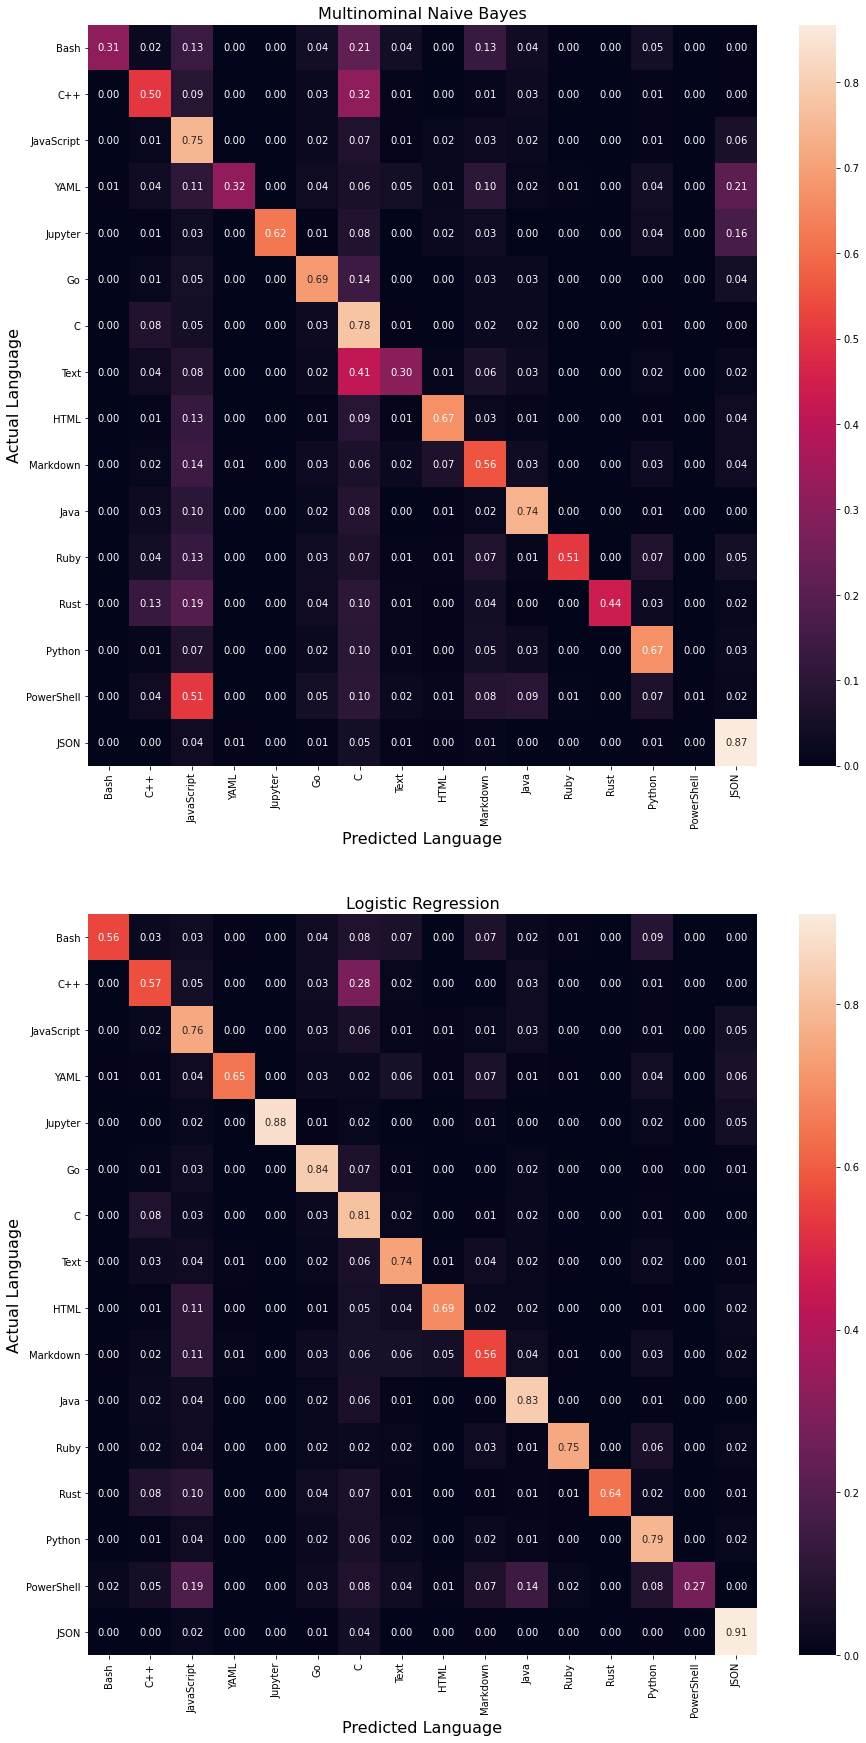

In [41]:
def generate_confusion_heatmap(model, axis):
    confusion = confusion_matrix(y_test.idxmax(axis=1), model.predict(X_test))
    confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    sns.heatmap(confusion, annot=True, fmt='.2f', xticklabels=languages, yticklabels=languages, ax=axis)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 30))
generate_confusion_heatmap(mnb, ax1)
generate_confusion_heatmap(lr, ax2)
ax1.set_title("Multinominal Naive Bayes")
ax2.set_title("Logistic Regression")
ax1.set_xlabel("Predicted Language")
ax1.set_ylabel("Actual Language")
ax2.set_xlabel("Predicted Language")
ax2.set_ylabel("Actual Language")

#disp.plot(include_values = False, ax=ax1, xticks_rotation="vertical")
plt.show()